## NA4AI - hw8

**Author: Adriana Bukala**
**Index number: 394064**

Used PC:
* 6-years old ASUS,
* SSD disc,
* 8GB of RAM,
* procesor intel core i7.

Side-note: I didn't use tensor notation, because it was too exhausting for my computer.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist
import time

In [2]:
# add bias
x_train = np.ones((60000, 785))
x_test = np.ones((10000, 785))

(x1, y_train), (x2, y_test) = mnist.load_data()

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x1 = x1.reshape(-1, 784)
x2 = x2.reshape(-1, 784)

x_train[:, :-1] = x1
x_test[:, :-1] = x2

# normalize
x_train = (x_train / 255).astype('float32')
x_test = (x_test / 255).astype('float32')

In [3]:
y_train.shape, x_train.shape, x_test.shape

((60000, 10), (60000, 785), (10000, 785))

In [4]:
def sigmoid(x, derivative=False):
    if derivative:
        return sigmoid(x) * (1 - sigmoid(x))
    return 1 / (1 + np.exp(-x))

def softmax(x, derivative=False):
    exps = np.exp(x - np.max(x, axis=0))
    if derivative:
        return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
    return exps / np.sum(exps, axis=0)

In [5]:
def cross_entropy_loss(pred, y):
    return -np.sum(y * np.log(pred + 1e-20))

### SGD + Adam implementation

In [6]:
class NeuralNetwork():
    def __init__(self):
        self.epochs = None
        self.l_rate = None
        self._lambda = None

        self.params = {}
        self.activations = []
        self.n_layers = 0
        
        self.mts = {}
        self.vts = {}
    
    def add_layer(self, n, activation, input_size=None):
        """Add new layer.
        
        Parameters
        ----------
        n : int
            Size of the first dimension of the new layer.
        activation : {linear, sigmoid, softmax}
        input_size : int
            When declaring a first layer, input_size is required.
        """
        
        if not self.params:
            self.params['W1'] = .1 * np.random.randn(n, input_size)
        else:
            # create a weights matrix of size (n, 1st dim of previous layer)
            self.params[f'W{self.n_layers + 1}'] = .1 * np.random.randn(
                n, self.params[f'W{self.n_layers}'].shape[0]
            )
        self.n_layers += 1
        self.activations.append(activation)
        
        self.mts[f'W{self.n_layers}'] = 0
        self.vts[f'W{self.n_layers}'] = 0


    def forward_pass(self, x_train):
        """Forward pass of neural network.
        
        Nodes computed by dot operation of current weight matrix (let's say of index k),
        and previous node value (k - 1) are denoted Z_k. After using activation, nodes
        are denoted A_k.
        """
        
        params = self.params
        params['A0'] = x_train.T
        
        for i in range(1, self.n_layers + 1):
            params[f'Z{i}'] = np.dot(params[f'W{i}'], params[f'A{i - 1}'])
            
            if self.activations[i - 1] == 'sigmoid':
                params[f'A{i}'] = sigmoid(params[f'Z{i}'])
            elif self.activations[i - 1] == 'softmax':
                params[f'A{i}'] = softmax(params[f'Z{i}'])
            else:
                params[f'A{i}'] = params[f'Z{i}']
        
        return params[f'A{self.n_layers}']

    def backward_pass(self, y_train, output):
        """Backward pass of neural network."""
        
        params = self.params
        updates = {}
        
        # starting with last layer
        for i in reversed(range(1, self.n_layers + 1)):
            # compute error
            if i == self.n_layers:
                error = (output - y_train)
            else:
                error = np.dot(params[f'W{i + 1}'].T, error)
            
            # multiply it by a derivative of activation function
            if self.activations[i - 1] == 'sigmoid':
                error *= sigmoid(params[f'Z{i}'], derivative=True)
            elif self.activations[i - 1] == 'softmax':
                error *= softmax(params[f'Z{i}'], derivative=True)

            updates[f'W{i}'] = np.dot(error, params[f'A{i-1}'].T) / error.shape[1]

        return updates

    def update_network_parameters(self, updates):
        """Update weights with additional regularization.."""
        
        for layer, value in updates.items():
            self.params[layer] -= self.l_rate * value + 2 * self._lambda * self.params[layer]
    
    def update_network_parameters_adam(self, updates, t, beta1, beta2, eps):
        """Update weights using Adam optimizer and, optionally, regularization."""
        
        for layer, value in updates.items():
            m = self.mts[layer]
            v = self.vts[layer]
                
            m = beta1 * m + (1 - beta1) * value
            mt = m / (1 - beta1 ** t)
            v = beta2 * v + (1 - beta2) * (value ** 2)
            vt = v / (1 - beta2 ** t)
            
            self.params[layer] -= (self.l_rate * mt / (np.sqrt(vt) + eps))
            self.params[layer] -= 2 * self._lambda * self.params[layer]
            self.mts[layer] = m
            self.vts[layer] = v
    

    def compute_accuracy(self, x, y):
        """Compute accuracy for a given data."""
        
        output = self.forward_pass(x)
        predictions = np.argmax(output, axis=0)
        y = np.argmax(y, axis=1)
        
        return np.mean(predictions == y)

    def train(self, x_train, y_train, batch_size, epochs=10, l_rate=0.001, _lambda=1e-5,
             adam=False, beta1=0.9, beta2=0.999, eps=0.1):
        """Train neural network."""
        
        self.epochs = epochs
        self.l_rate = l_rate
        self._lambda = _lambda
        
        start_time = time.time()
        n_batches = x_train.shape[0] // batch_size
        history = {'acc': [], 'loss': []}
        
        for iteration in range(self.epochs):
            loss = 0
            
            # shuffle data differently each iteration
            np.random.seed(iteration)
            p = np.random.permutation(x_train.shape[0])
            x_train = x_train[p, :]
            y_train = y_train[p, :]
            
            # iterate over batches with keras-like parameter drop_last=True
            for j in range(0, x_train.shape[0] - batch_size + 1, batch_size):
                xs = x_train[j:j + batch_size, :]
                ys = y_train[j:j + batch_size, :].T
                
                output = self.forward_pass(xs)
                updates = self.backward_pass(ys, output)
                # update weights
                if adam:
                    self.update_network_parameters_adam(
                        updates, iteration + 1, beta1, beta2, eps
                    )
                else:
                    self.update_network_parameters(updates)
                
                # compute mean cross entropy loss of the whole batch
                loss += cross_entropy_loss(output, ys) / batch_size
            
            loss /= n_batches
            # add regularization penalty
            loss += self._lambda * np.sum(
                [np.sum(np.square(self.params[f'W{i}'])) for i in range(1, self.n_layers + 1)]
            )
            history['loss'].append(loss)
            
            accuracy = self.compute_accuracy(x_train, y_train)
            history['acc'].append(accuracy)
            
            if iteration % 10 == 0:
                print((
                    f'Epoch: {iteration}, Training time: {time.time() - start_time:.2f}s\n'
                    f'Loss: {loss:.5f}, Accuracy: {100 * accuracy:.2f}%'
                ))
        
        return history

### Shallow networks with linear activation

**SGD**

In [7]:
n = 785
m1 = 128
m2 = 64
n_classes = 10

In [8]:
np.random.seed(256)

In [9]:
nn1 = NeuralNetwork()
nn1.add_layer(input_size=n, n=m1, activation='linear')
nn1.add_layer(n=n_classes, activation='softmax')

In [10]:
history1 = nn1.train(
        x_train, 
        y_train,
        batch_size=1024, 
        l_rate=0.01,
        _lambda=0.00001,
        epochs=150,
)

Epoch: 0, Training time: 1.63s
Loss: 2.61920, Accuracy: 15.26%
Epoch: 10, Training time: 13.82s
Loss: 1.42251, Accuracy: 60.14%
Epoch: 20, Training time: 25.65s
Loss: 0.97178, Accuracy: 72.78%
Epoch: 30, Training time: 36.75s
Loss: 0.76901, Accuracy: 79.39%
Epoch: 40, Training time: 47.87s
Loss: 0.66743, Accuracy: 82.52%
Epoch: 50, Training time: 59.28s
Loss: 0.60766, Accuracy: 84.06%
Epoch: 60, Training time: 70.51s
Loss: 0.56831, Accuracy: 85.04%
Epoch: 70, Training time: 81.92s
Loss: 0.54078, Accuracy: 85.83%
Epoch: 80, Training time: 93.04s
Loss: 0.51975, Accuracy: 86.42%
Epoch: 90, Training time: 104.17s
Loss: 0.50317, Accuracy: 86.89%
Epoch: 100, Training time: 115.30s
Loss: 0.48994, Accuracy: 87.28%
Epoch: 110, Training time: 126.45s
Loss: 0.47947, Accuracy: 87.56%
Epoch: 120, Training time: 137.53s
Loss: 0.47005, Accuracy: 87.79%
Epoch: 130, Training time: 148.65s
Loss: 0.46253, Accuracy: 88.02%
Epoch: 140, Training time: 159.70s
Loss: 0.45535, Accuracy: 88.20%


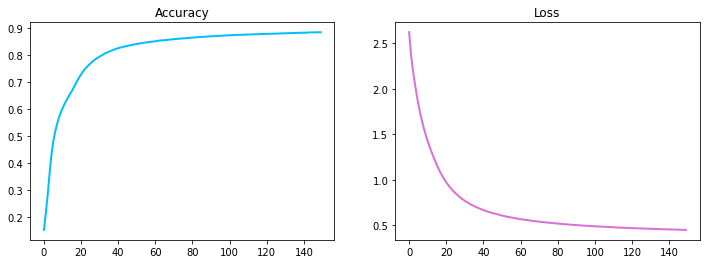

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history1['acc'], c='deepskyblue', lw=2)
ax1.set_title('Accuracy')
ax2.plot(history1['loss'], c='orchid', lw=2)
ax2.set_title('Loss')
plt.show()

In [12]:
y_pred = nn1.forward_pass(x_train)
y_pred = np.argmax(y_pred, axis=0).reshape(-1, 1)
y = np.argmax(y_train, axis=1).reshape(-1, 1)
print(f'Accuracy for train set: {accuracy_score(y, y_pred):.5f}')

Accuracy for train set: 0.88390


In [13]:
y_pred = nn1.forward_pass(x_test)
y_pred = np.argmax(y_pred, axis=0).reshape(-1, 1)
y = np.argmax(y_test, axis=1).reshape(-1, 1)
print(f'Accuracy for test set: {accuracy_score(y, y_pred):.5f}')

Accuracy for test set: 0.89030


**Adam**

In [14]:
np.random.seed(256)

nn2 = NeuralNetwork()
nn2.add_layer(input_size=n, n=m1, activation='linear')
nn2.add_layer(n=n_classes, activation='softmax')

In [15]:
history2 = nn2.train(
        x_train,
        y_train,
        batch_size=256, 
        l_rate=0.0001,
        _lambda=0.00001,
        epochs=100,
        adam=True,
        beta1=0.9, 
        beta2=0.999, 
        eps=1e-8,
)

Epoch: 0, Training time: 1.73s
Loss: 1.22714, Accuracy: 80.45%
Epoch: 10, Training time: 18.61s
Loss: 0.43572, Accuracy: 89.17%
Epoch: 20, Training time: 35.26s
Loss: 0.38696, Accuracy: 90.45%
Epoch: 30, Training time: 51.86s
Loss: 0.36178, Accuracy: 91.03%
Epoch: 40, Training time: 68.55s
Loss: 0.34607, Accuracy: 91.49%
Epoch: 50, Training time: 85.25s
Loss: 0.33566, Accuracy: 91.76%
Epoch: 60, Training time: 101.99s
Loss: 0.32831, Accuracy: 92.00%
Epoch: 70, Training time: 118.70s
Loss: 0.32416, Accuracy: 92.18%
Epoch: 80, Training time: 137.09s
Loss: 0.32122, Accuracy: 92.26%
Epoch: 90, Training time: 153.92s
Loss: 0.31976, Accuracy: 92.40%


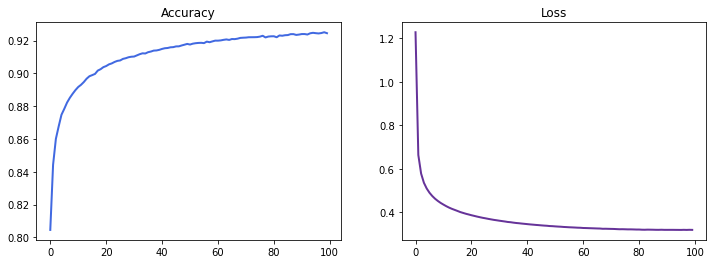

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history2['acc'], c='royalblue', lw=2)
ax1.set_title('Accuracy')
ax2.plot(history2['loss'], c='rebeccapurple', lw=2)
ax2.set_title('Loss')
plt.show()

In [17]:
y_pred = nn2.forward_pass(x_train)
y_pred = np.argmax(y_pred, axis=0).reshape(-1, 1)
y = np.argmax(y_train, axis=1).reshape(-1, 1)
print(f'Accuracy for train set: {accuracy_score(y, y_pred):.5f}')

Accuracy for train set: 0.92450


In [18]:
y_pred = nn2.forward_pass(x_test)
y_pred = np.argmax(y_pred, axis=0).reshape(-1, 1)
y = np.argmax(y_test, axis=1).reshape(-1, 1)
print(f'Accuracy for test set: {accuracy_score(y, y_pred):.5f}')

Accuracy for test set: 0.92360


### Shallow networks with sigmoid activation

**SGD**

In [19]:
np.random.seed(256)
nn3 = NeuralNetwork()
nn3.add_layer(input_size=n, n=m1, activation='sigmoid')
nn3.add_layer(n=n_classes, activation='softmax')

In [20]:
history3 = nn3.train(
        x_train, 
        y_train,
        batch_size=128,
        l_rate=0.1,
        _lambda=0.00001,
        epochs=150,
)

Epoch: 0, Training time: 2.55s
Loss: 2.03874, Accuracy: 55.04%
Epoch: 10, Training time: 28.09s
Loss: 4.94148, Accuracy: 74.72%
Epoch: 20, Training time: 52.89s
Loss: 4.84894, Accuracy: 78.67%
Epoch: 30, Training time: 77.70s
Loss: 2.82821, Accuracy: 79.81%
Epoch: 40, Training time: 102.83s
Loss: 2.21454, Accuracy: 80.86%
Epoch: 50, Training time: 129.41s
Loss: 2.07529, Accuracy: 81.33%
Epoch: 60, Training time: 154.77s
Loss: 2.00020, Accuracy: 81.64%
Epoch: 70, Training time: 179.88s
Loss: 1.95261, Accuracy: 81.74%
Epoch: 80, Training time: 205.15s
Loss: 1.92741, Accuracy: 81.86%
Epoch: 90, Training time: 230.19s
Loss: 1.90676, Accuracy: 81.93%
Epoch: 100, Training time: 258.11s
Loss: 1.89009, Accuracy: 82.14%
Epoch: 110, Training time: 285.71s
Loss: 1.88723, Accuracy: 82.16%
Epoch: 120, Training time: 313.12s
Loss: 1.87180, Accuracy: 82.20%
Epoch: 130, Training time: 342.31s
Loss: 1.88205, Accuracy: 82.27%
Epoch: 140, Training time: 369.12s
Loss: 1.87416, Accuracy: 82.41%


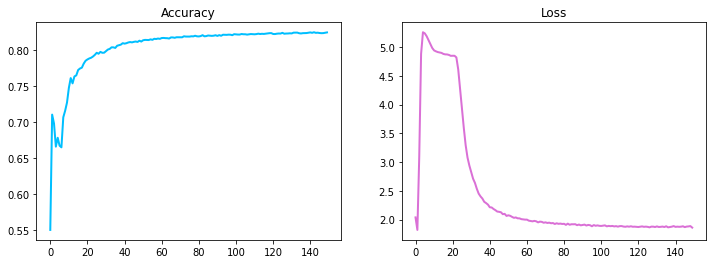

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history3['acc'], c='deepskyblue', lw=2)
ax1.set_title('Accuracy')
ax2.plot(history3['loss'], c='orchid', lw=2)
ax2.set_title('Loss')
plt.show()

In [22]:
y_pred = nn3.forward_pass(x_train)
y_pred = np.argmax(y_pred, axis=0).reshape(-1, 1)
y = np.argmax(y_train, axis=1).reshape(-1, 1)
print(f'Accuracy for train set: {accuracy_score(y, y_pred):.5f}')

Accuracy for train set: 0.82415


In [23]:
y_pred = nn3.forward_pass(x_test)
y_pred = np.argmax(y_pred, axis=0).reshape(-1, 1)
y = np.argmax(y_test, axis=1).reshape(-1, 1)
print(f'Accuracy for test set: {accuracy_score(y, y_pred):.5f}')

Accuracy for test set: 0.82520


**Adam**

In [24]:
np.random.seed(256)

nn4 = NeuralNetwork()
nn4.add_layer(input_size=n, n=m1, activation='sigmoid')
nn4.add_layer(n=n_classes, activation='softmax')

In [25]:
history4 = nn4.train(
        x_train,
        y_train,
        batch_size=256, 
        l_rate=0.0001,
        _lambda=0.00001,
        epochs=350,
        adam=True,
        beta1=0.9, 
        beta2=0.999, 
        eps=1e-8,
)

Epoch: 0, Training time: 2.96s
Loss: 1.88991, Accuracy: 63.62%
Epoch: 10, Training time: 32.10s
Loss: 1.20605, Accuracy: 78.82%
Epoch: 20, Training time: 61.54s
Loss: 1.20142, Accuracy: 80.72%
Epoch: 30, Training time: 90.69s
Loss: 1.23439, Accuracy: 81.62%
Epoch: 40, Training time: 119.79s
Loss: 1.24346, Accuracy: 81.33%
Epoch: 50, Training time: 148.91s
Loss: 1.21027, Accuracy: 81.55%
Epoch: 60, Training time: 178.21s
Loss: 1.15110, Accuracy: 82.47%
Epoch: 70, Training time: 207.63s
Loss: 1.06930, Accuracy: 85.05%
Epoch: 80, Training time: 236.95s
Loss: 0.99199, Accuracy: 87.10%
Epoch: 90, Training time: 266.08s
Loss: 0.92513, Accuracy: 87.94%
Epoch: 100, Training time: 295.36s
Loss: 0.87485, Accuracy: 88.56%
Epoch: 110, Training time: 324.57s
Loss: 0.83963, Accuracy: 88.92%
Epoch: 120, Training time: 353.59s
Loss: 0.80172, Accuracy: 89.22%
Epoch: 130, Training time: 382.64s
Loss: 0.77063, Accuracy: 89.49%
Epoch: 140, Training time: 412.00s
Loss: 0.74036, Accuracy: 89.66%
Epoch: 150,

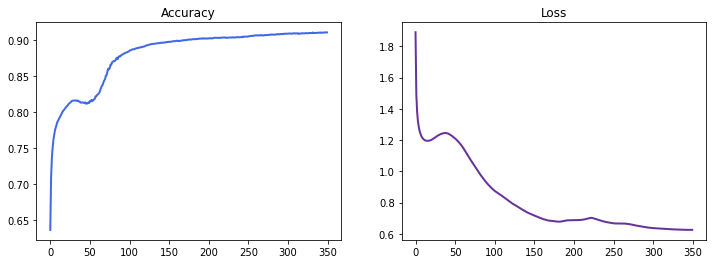

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history4['acc'], c='royalblue', lw=2)
ax1.set_title('Accuracy')
ax2.plot(history4['loss'], c='rebeccapurple', lw=2)
ax2.set_title('Loss')
plt.show()

In [27]:
y_pred = nn4.forward_pass(x_train)
y_pred = np.argmax(y_pred, axis=0).reshape(-1, 1)
y = np.argmax(y_train, axis=1).reshape(-1, 1)
print(f'Accuracy for train set: {accuracy_score(y, y_pred):.5f}')

Accuracy for train set: 0.91085


In [28]:
y_pred = nn4.forward_pass(x_test)
y_pred = np.argmax(y_pred, axis=0).reshape(-1, 1)
y = np.argmax(y_test, axis=1).reshape(-1, 1)
print(f'Accuracy for test set: {accuracy_score(y, y_pred):.5f}')

Accuracy for test set: 0.91210


### Two-layered networks with linear activation

**SGD**

In [67]:
np.random.seed(256)

nn5 = NeuralNetwork()
nn5.add_layer(input_size=n, n=m1, activation='linear')
nn5.add_layer(n=m2, activation='linear')
nn5.add_layer(n=n_classes, activation='softmax')

In [68]:
history5 = nn5.train(
        x_train, 
        y_train,
        batch_size=512, 
        l_rate=0.001,
        _lambda=0.00001,
        epochs=200,
)

Epoch: 0, Training time: 1.23s
Loss: 2.76780, Accuracy: 9.30%
Epoch: 10, Training time: 13.49s
Loss: 2.37447, Accuracy: 20.10%
Epoch: 20, Training time: 25.61s
Loss: 2.09914, Accuracy: 35.43%
Epoch: 30, Training time: 37.79s
Loss: 1.89071, Accuracy: 44.04%
Epoch: 40, Training time: 50.29s
Loss: 1.72848, Accuracy: 51.26%
Epoch: 50, Training time: 62.44s
Loss: 1.59755, Accuracy: 57.34%
Epoch: 60, Training time: 74.58s
Loss: 1.48930, Accuracy: 61.84%
Epoch: 70, Training time: 86.71s
Loss: 1.39788, Accuracy: 64.94%
Epoch: 80, Training time: 98.87s
Loss: 1.32050, Accuracy: 67.02%
Epoch: 90, Training time: 111.03s
Loss: 1.25345, Accuracy: 68.88%
Epoch: 100, Training time: 123.18s
Loss: 1.19334, Accuracy: 70.56%
Epoch: 110, Training time: 135.37s
Loss: 1.13841, Accuracy: 72.47%
Epoch: 120, Training time: 147.53s
Loss: 1.08831, Accuracy: 74.78%
Epoch: 130, Training time: 159.80s
Loss: 1.04681, Accuracy: 76.57%
Epoch: 140, Training time: 172.07s
Loss: 1.01376, Accuracy: 77.49%
Epoch: 150, Train

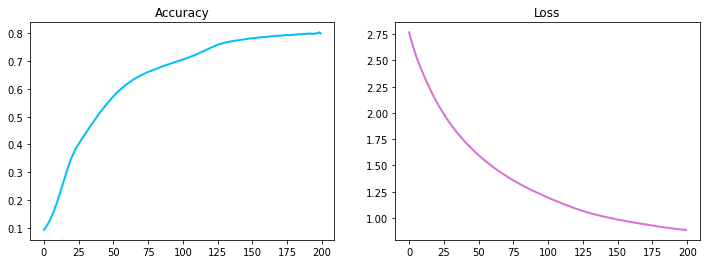

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history5['acc'], c='deepskyblue', lw=2)
ax1.set_title('Accuracy')
ax2.plot(history5['loss'], c='orchid', lw=2)
ax2.set_title('Loss')
plt.show()

In [70]:
y_pred = nn5.forward_pass(x_train)
y_pred = np.argmax(y_pred, axis=0).reshape(-1, 1)
y = np.argmax(y_train, axis=1).reshape(-1, 1)
print(f'Accuracy for train set: {accuracy_score(y, y_pred):.5f}')

Accuracy for train set: 0.79887


In [71]:
y_pred = nn5.forward_pass(x_test)
y_pred = np.argmax(y_pred, axis=0).reshape(-1, 1)
y = np.argmax(y_test, axis=1).reshape(-1, 1)
print(f'Accuracy for test set: {accuracy_score(y, y_pred):.5f}')

Accuracy for test set: 0.80270


**Adam**

In [40]:
np.random.seed(256)

nn6 = NeuralNetwork()
nn6.add_layer(input_size=n, n=m1, activation='linear')
nn6.add_layer(n=m2, activation='linear')
nn6.add_layer(n=n_classes, activation='softmax')

In [41]:
history6 = nn6.train(
        x_train,
        y_train,
        batch_size=256, 
        l_rate=0.00001,
        _lambda=0.000001,
        epochs=300,
        adam=True,
        beta1=0.9, 
        beta2=0.999, 
        eps=1e-8,
)

Epoch: 0, Training time: 1.86s
Loss: 2.43191, Accuracy: 28.42%
Epoch: 10, Training time: 20.06s
Loss: 1.46801, Accuracy: 60.69%
Epoch: 20, Training time: 38.34s
Loss: 1.14002, Accuracy: 70.47%
Epoch: 30, Training time: 56.51s
Loss: 0.92503, Accuracy: 76.62%
Epoch: 40, Training time: 75.00s
Loss: 0.78186, Accuracy: 80.09%
Epoch: 50, Training time: 93.28s
Loss: 0.68216, Accuracy: 82.49%
Epoch: 60, Training time: 111.46s
Loss: 0.61166, Accuracy: 84.34%
Epoch: 70, Training time: 129.75s
Loss: 0.56061, Accuracy: 85.66%
Epoch: 80, Training time: 147.96s
Loss: 0.52231, Accuracy: 86.67%
Epoch: 90, Training time: 166.12s
Loss: 0.49218, Accuracy: 87.41%
Epoch: 100, Training time: 184.71s
Loss: 0.46931, Accuracy: 88.02%
Epoch: 110, Training time: 203.11s
Loss: 0.45089, Accuracy: 88.46%
Epoch: 120, Training time: 221.30s
Loss: 0.43663, Accuracy: 88.81%
Epoch: 130, Training time: 239.54s
Loss: 0.42560, Accuracy: 89.09%
Epoch: 140, Training time: 257.75s
Loss: 0.41694, Accuracy: 89.32%
Epoch: 150, T

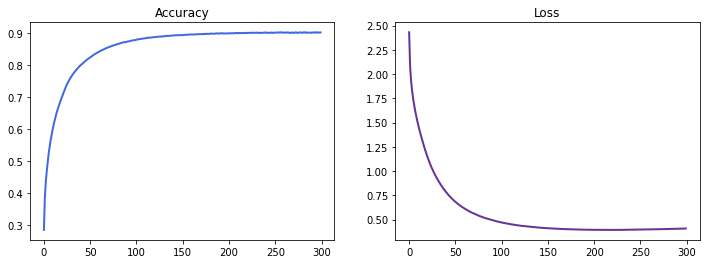

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history6['acc'], c='royalblue', lw=2)
ax1.set_title('Accuracy')
ax2.plot(history6['loss'], c='rebeccapurple', lw=2)
ax2.set_title('Loss')
plt.show()

In [43]:
y_pred = nn6.forward_pass(x_train)
y_pred = np.argmax(y_pred, axis=0).reshape(-1, 1)
y = np.argmax(y_train, axis=1).reshape(-1, 1)
print(f'Accuracy for train set: {accuracy_score(y, y_pred):.5f}')

Accuracy for train set: 0.90267


In [44]:
y_pred = nn6.forward_pass(x_test)
y_pred = np.argmax(y_pred, axis=0).reshape(-1, 1)
y = np.argmax(y_test, axis=1).reshape(-1, 1)
print(f'Accuracy for test set: {accuracy_score(y, y_pred):.5f}')

Accuracy for test set: 0.90630


### Two-layered networks with sigmoid activation

**SGD**

In [60]:
np.random.seed(256)

nn7 = NeuralNetwork()
nn7.add_layer(input_size=n, n=m1, activation='sigmoid')
nn7.add_layer(n=m2, activation='sigmoid')
nn7.add_layer(n=n_classes, activation='softmax')

In [61]:
history7 = nn7.train(
        x_train, 
        y_train,
        batch_size=256,
        l_rate=0.1,
        _lambda=0.00001,
        epochs=200,
)

Epoch: 0, Training time: 3.17s
Loss: 2.32683, Accuracy: 11.67%
Epoch: 10, Training time: 34.54s
Loss: 2.03811, Accuracy: 27.81%
Epoch: 20, Training time: 68.71s
Loss: 1.75212, Accuracy: 40.70%
Epoch: 30, Training time: 99.52s
Loss: 1.57940, Accuracy: 45.17%
Epoch: 40, Training time: 130.56s
Loss: 1.43642, Accuracy: 53.32%
Epoch: 50, Training time: 161.68s
Loss: 1.34510, Accuracy: 60.81%
Epoch: 60, Training time: 192.47s
Loss: 1.26453, Accuracy: 64.68%
Epoch: 70, Training time: 223.28s
Loss: 1.20444, Accuracy: 68.84%
Epoch: 80, Training time: 254.29s
Loss: 1.16728, Accuracy: 67.36%
Epoch: 90, Training time: 285.12s
Loss: 1.14092, Accuracy: 71.04%
Epoch: 100, Training time: 315.96s
Loss: 1.11273, Accuracy: 74.02%
Epoch: 110, Training time: 346.81s
Loss: 1.08244, Accuracy: 74.27%
Epoch: 120, Training time: 378.11s
Loss: 1.05137, Accuracy: 74.84%
Epoch: 130, Training time: 408.89s
Loss: 1.02353, Accuracy: 76.14%
Epoch: 140, Training time: 439.80s
Loss: 1.00048, Accuracy: 76.27%
Epoch: 150,

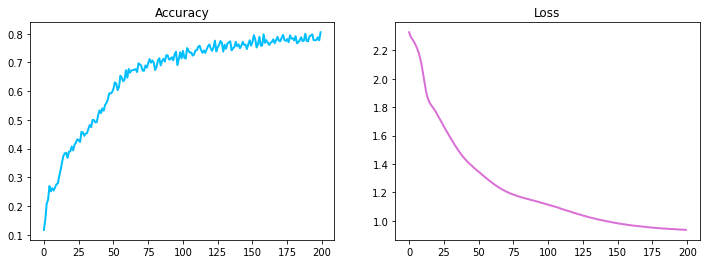

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history7['acc'], c='deepskyblue', lw=2)
ax1.set_title('Accuracy')
ax2.plot(history7['loss'], c='orchid', lw=2)
ax2.set_title('Loss')
plt.show()

In [63]:
y_pred = nn7.forward_pass(x_train)
y_pred = np.argmax(y_pred, axis=0).reshape(-1, 1)
y = np.argmax(y_train, axis=1).reshape(-1, 1)
print(f'Accuracy for train set: {accuracy_score(y, y_pred):.5f}')

Accuracy for train set: 0.80513


In [64]:
y_pred = nn7.forward_pass(x_test)
y_pred = np.argmax(y_pred, axis=0).reshape(-1, 1)
y = np.argmax(y_test, axis=1).reshape(-1, 1)
print(f'Accuracy for test set: {accuracy_score(y, y_pred):.5f}')

Accuracy for test set: 0.80710


**Adam**

In [52]:
np.random.seed(256)

nn8 = NeuralNetwork()
nn8.add_layer(input_size=n, n=m1, activation='sigmoid')
nn8.add_layer(n=m2, activation='sigmoid')
nn8.add_layer(n=n_classes, activation='softmax')

In [53]:
history8 = nn8.train(
        x_train,
        y_train,
        batch_size=256, 
        l_rate=0.0001,
        _lambda=0.00001,
        epochs=230,
        adam=True,
        beta1=0.9, 
        beta2=0.999, 
        eps=1e-8,
)

Epoch: 0, Training time: 4.42s
Loss: 2.19064, Accuracy: 38.81%
Epoch: 10, Training time: 40.42s
Loss: 1.59195, Accuracy: 63.81%
Epoch: 20, Training time: 76.35s
Loss: 1.43420, Accuracy: 67.54%
Epoch: 30, Training time: 112.15s
Loss: 1.31581, Accuracy: 70.86%
Epoch: 40, Training time: 148.00s
Loss: 1.20278, Accuracy: 77.34%
Epoch: 50, Training time: 184.04s
Loss: 1.08896, Accuracy: 82.32%
Epoch: 60, Training time: 219.89s
Loss: 0.98508, Accuracy: 85.60%
Epoch: 70, Training time: 255.68s
Loss: 0.88932, Accuracy: 87.60%
Epoch: 80, Training time: 291.80s
Loss: 0.80365, Accuracy: 88.72%
Epoch: 90, Training time: 327.75s
Loss: 0.72798, Accuracy: 89.48%
Epoch: 100, Training time: 363.58s
Loss: 0.66918, Accuracy: 90.21%
Epoch: 110, Training time: 399.69s
Loss: 0.62278, Accuracy: 90.77%
Epoch: 120, Training time: 435.50s
Loss: 0.58237, Accuracy: 91.25%
Epoch: 130, Training time: 471.38s
Loss: 0.54715, Accuracy: 91.65%
Epoch: 140, Training time: 507.19s
Loss: 0.51589, Accuracy: 92.06%
Epoch: 150

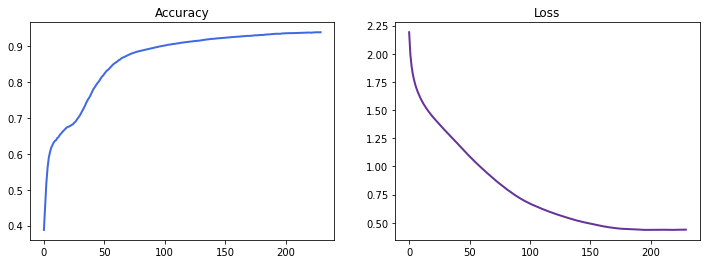

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history8['acc'], c='royalblue', lw=2)
ax1.set_title('Accuracy')
ax2.plot(history8['loss'], c='rebeccapurple', lw=2)
ax2.set_title('Loss')
plt.show()

In [55]:
y_pred = nn8.forward_pass(x_train)
y_pred = np.argmax(y_pred, axis=0).reshape(-1, 1)
y = np.argmax(y_train, axis=1).reshape(-1, 1)
print(f'Accuracy for train set: {accuracy_score(y, y_pred):.5f}')

Accuracy for train set: 0.93897


In [56]:
y_pred = nn8.forward_pass(x_test)
y_pred = np.argmax(y_pred, axis=0).reshape(-1, 1)
y = np.argmax(y_test, axis=1).reshape(-1, 1)
print(f'Accuracy for test set: {accuracy_score(y, y_pred):.5f}')

Accuracy for test set: 0.93690


### Deep network (> 5 hidden layers)

50 epochs and linear activations, because of lower computational cost; just for demonstration.

In [72]:
np.random.seed(256)

nn9 = NeuralNetwork()
nn9.add_layer(input_size=n, n=256, activation='linear')

nn9.add_layer(n=128, activation='linear')
nn9.add_layer(n=128, activation='linear')
nn9.add_layer(n=64, activation='linear')
nn9.add_layer(n=64, activation='linear')
nn9.add_layer(n=32, activation='linear')

nn9.add_layer(n=n_classes, activation='softmax')

In [73]:
history9 = nn9.train(
        x_train,
        y_train,
        batch_size=256, 
        l_rate=0.00001,
        _lambda=0.000001,
        epochs=50,
        adam=True,
        beta1=0.9, 
        beta2=0.999, 
        eps=1e-8,
)

Epoch: 0, Training time: 4.18s
Loss: 2.07763, Accuracy: 45.32%
Epoch: 10, Training time: 41.83s
Loss: 0.91163, Accuracy: 77.38%
Epoch: 20, Training time: 79.78s
Loss: 0.74581, Accuracy: 80.88%
Epoch: 30, Training time: 117.50s
Loss: 0.66174, Accuracy: 82.70%
Epoch: 40, Training time: 155.15s
Loss: 0.62520, Accuracy: 83.69%


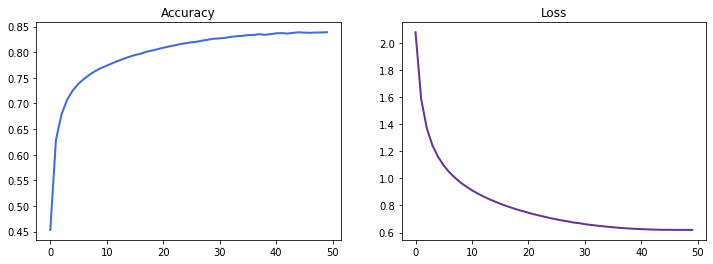

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history9['acc'], c='royalblue', lw=2)
ax1.set_title('Accuracy')
ax2.plot(history9['loss'], c='rebeccapurple', lw=2)
ax2.set_title('Loss')
plt.show()